In [1]:
import os
import math

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (14, 8)


In [3]:
api_token = os.environ["NEPTUNE_API_TOKEN"]

run = neptune.init(project="sign-language/MNIST-sign-language", api_token=api_token)
neptune_callback = NeptuneCallback(run=run, base_namespace="metrics")

https://app.neptune.ai/sign-language/MNIST-sign-language/e/MNIS-6
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


<center> <h2> Problem and dataset description

The dataset is "MNIST sign language" that resembles closely the classic MNIST dataset.<br>
Each training and test case represents a label (0-25) for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255. 

The original hand gesture image data represented multiple users repeating the gesture against different backgrounds. The dataset was created from extending and cropping images from much smaller dataset. An image pipeline was used based on ImageMagick and included cropping to hands-only, gray-scaling, resizing, and then creating at least 50+ variations to enlarge the quantity.

Link to the dataset can be found [here](https://www.kaggle.com/datamunge/sign-language-mnist).

<center> <h2> Data overview

In [4]:
ROOT_PATH = Path().resolve().parent

DATA_PATH = ROOT_PATH.joinpath("data")
CHECKPOINT_PATH = ROOT_PATH.joinpath("clf_checkpoints")

MNIST_TRAIN = DATA_PATH.joinpath("sign_mnist_train.csv")
MNIST_TEST = DATA_PATH.joinpath("sign_mnist_test.csv")


In [5]:
train_df = pd.read_csv(MNIST_TRAIN)
test_df = pd.read_csv(MNIST_TEST)


In [6]:
print(f"Number of train examples : {train_df.shape[0]}")
print(f"Number of test examples  : {test_df.shape[0]}")

Number of train examples : 27455
Number of test examples  : 7172


In [7]:
test = pd.read_csv(MNIST_TEST)
y = test["label"]


In [8]:
train_df.head()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


<center> <h2> Preprocessing

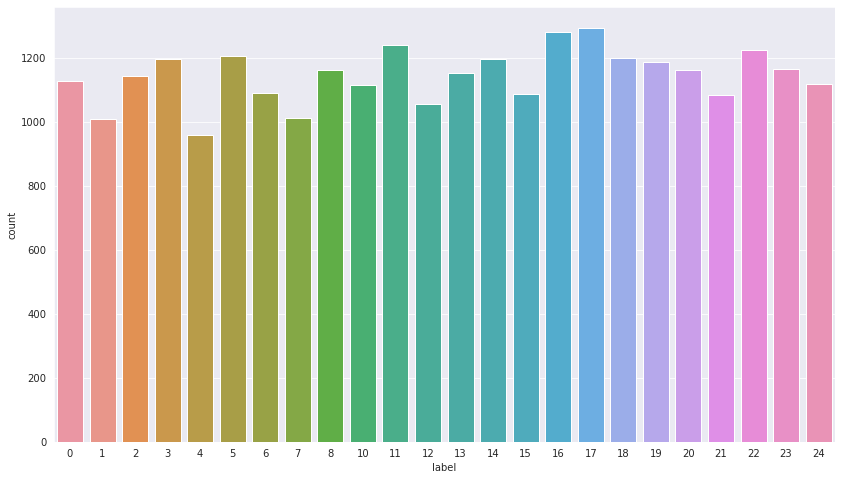

In [9]:
_ = sns.countplot(x=train_df["label"])


As we can see, the distribution of each label is fairly even thus the dataset is balanced. As mentioned earlier, the images are all grayscale and the pixel values are between 0-255. The images are resized to 28x28 pixels.

In [10]:
y_train, X_train_df = train_df["label"], train_df.drop("label", axis=1)
y_test, X_test_df = test_df["label"], test_df.drop("label", axis=1)


In [11]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)


In [12]:
x_train = X_train_df.values
x_test = X_test_df.values


In [13]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255


In [14]:
# Reshaping the to an image with single chanel
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)


<center> <h3> Preview of first the images

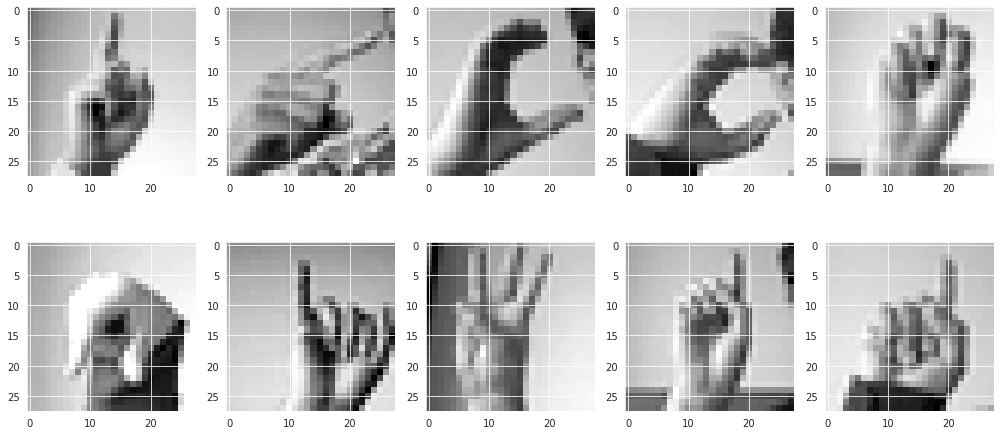

In [15]:
rows, cols = (2, 5)

f, ax = plt.subplots(rows, cols)
for i in range(rows):
    for j in range(cols):
        ax[i, j].imshow(x_train[i * cols + j].reshape(28, 28), cmap="gray")
    plt.tight_layout()

plt.show()



<center> <h2> Data Augmentation


Train data is augmented to prevent overfitting and to increase the generalization ability of the model.

Augmented options contain:
 - Rotation of the image
 - Random shifting of the image in width or height

No flip was introduced as it could in fact change the real meaning of the image (different label).

In [16]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
)

datagen.fit(x_train)


<center> <h2> The Model

We've decided to use single architecture consisting of three convolutional layers and two fully connected layers.

Each convolutional layer has a kernel size of 3x3 and a stride of 2x2 (except the first layer where we've decided to use 1x1 strides). A batch normalization and max pooling layers are also applied after each convolutional layer with optional Dropout layers to addionaly reduce overfitting.

At the end there are two fully connected layers with a dropout layer between them.

All the layers have ReLU activation function except the last one which has a softmax activation function as it is a classification problem so we want to predict the probability of each class (thus the output layer has the size of the number of classes).

In [17]:
model = Sequential()
model.add(
    Conv2D(
        75,
        (3, 3),
        strides=1,
        padding="same",
        activation="relu",
        input_shape=(28, 28, 1),
    )
)
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))

model.add(Conv2D(50, (3, 3), padding="same", activation="relu"))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))

model.add(Conv2D(25, (3, 3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(24, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 75)       300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 50)       2

2022-02-13 23:02:56.785297: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 23:02:56.851959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 23:02:56.852148: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 23:02:56.853495: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

We've decided to use total of 30 epochs and a batch size of 64 to train the model with a learning rate of 0.001.

We've also introduced several callbacks to monitor and adjust the learning rate during training. It consists of ModelCheckpoints which save the model every 5 epochs, EarlyStopping which stops the training if the validation loss doesn't improve for 5 epochs and ReduceLROnPlateau which reduces the learning rate if the validation loss doesn't improve for 3 epochs.

In [18]:
checkpoint_name = "classificator-{epoch:03d}.ckpt"

batch_size = 64
epochs = 30

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.00001
)

# Number of training examples / batch size = number of steps in each epoch
save_freq = math.ceil(train_df.shape[0] / batch_size)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH.joinpath(checkpoint_name),
    verbose=1,
    save_weights_only=True,
    save_freq=5*save_freq, # Save weights every 5 epochs
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0.005, patience=5, verbose=1, mode="auto"
)

In [19]:
model.save_weights(CHECKPOINT_PATH.joinpath(checkpoint_name.format(epoch=0)))

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[
        learning_rate_reduction, checkpoint_callback, early_stopping_callback, neptune_callback
    ],
)

model.save_weights(CHECKPOINT_PATH.joinpath(checkpoint_name.format(epoch=history.epoch[-1])))


Epoch 1/30


2022-02-13 23:02:59.484850: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8301


429/429 [==============================] - 13s 26ms/step - loss: 0.8908 - accuracy: 0.7167 - val_loss: 1.8831 - val_accuracy: 0.4472 - lr: 0.0010
Epoch 2/30
429/429 [==============================] - 12s 27ms/step - loss: 0.1809 - accuracy: 0.9394 - val_loss: 0.2662 - val_accuracy: 0.9018 - lr: 0.0010
Epoch 3/30
429/429 [==============================] - 13s 29ms/step - loss: 0.0953 - accuracy: 0.9693 - val_loss: 0.6995 - val_accuracy: 0.7811 - lr: 0.0010
Epoch 4/30
429/429 [==============================] - 12s 28ms/step - loss: 0.0627 - accuracy: 0.9792 - val_loss: 0.2723 - val_accuracy: 0.9205 - lr: 0.0010
Epoch 5/30
426/429 [============================>.] - ETA: 0s - loss: 0.0532 - accuracy: 0.9820
Epoch 5: saving model to /home/gonk/Repositories/MNIST-sign-language/clf_checkpoints/classificator-005.ckpt
429/429 [==============================] - 12s 27ms/step - loss: 0.0537 - accuracy: 0.9818 - val_loss: 0.0283 - val_accuracy: 0.9901 - lr: 0.0010
Epoch 6/30
429/429 [=============

As we can see early stopping callback worked, stopping the training after 18 epochs.<br>
The accuracy of the model is almost at 100% after this training process.

In [20]:
print("Accuracy of the model: ", model.evaluate(x_test, y_test)[1] * 100, "%")


225/225 [==============================] - 1s 3ms/step - loss: 0.0088 - accuracy: 0.9974
Accuracy of the model:  99.7350811958313 %


<center> <h2> Model Overview

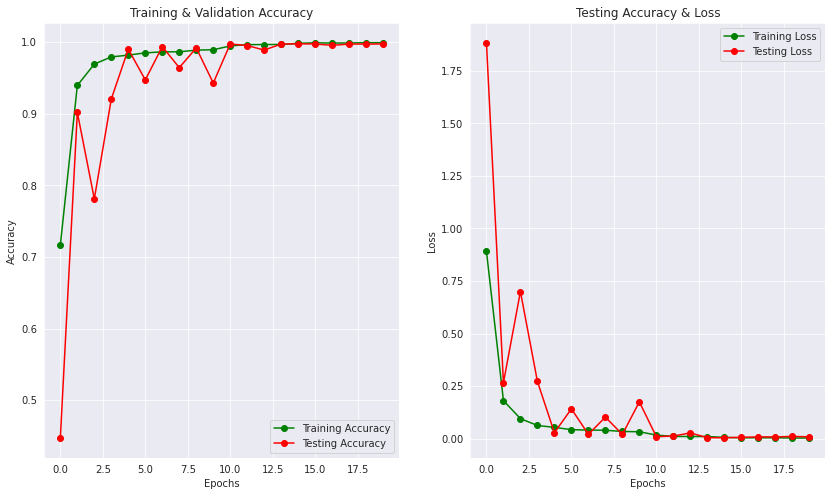

In [21]:
fig, ax = plt.subplots(1, 2)
epochs = history.epoch
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

ax[0].plot(epochs, train_acc, "go-", label="Training Accuracy")
ax[0].plot(epochs, val_acc, "ro-", label="Testing Accuracy")
ax[0].set_title("Training & Validation Accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, "g-o", label="Training Loss")
ax[1].plot(epochs, val_loss, "r-o", label="Testing Loss")
ax[1].set_title("Testing Accuracy & Loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()


In [22]:
predictions = np.argmax(model.predict(x_test), axis=-1)
for i in range(len(predictions)):
    if predictions[i] >= 9:
        predictions[i] += 1
predictions[:5]


array([ 6,  5, 10,  0,  3])

In [23]:
x_test.shape


(7172, 28, 28, 1)

In [24]:
classes = ["Class " + str(i) for i in range(25) if i != 9]

print(predictions.shape, y.shape)
print(classification_report(y, predictions, target_names=classes))


(7172,) (7172,)
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      1.00      1.00       245
     Class 4       0.96      1.00      0.98       498
     Class 5       1.00      1.00      1.00       247
     Class 6       1.00      0.95      0.97       348
     Class 7       1.00      1.00      1.00       436
     Class 8       1.00      1.00      1.00       288
    Class 10       1.00      1.00      1.00       331
    Class 11       1.00      1.00      1.00       209
    Class 12       1.00      1.00      1.00       394
    Class 13       1.00      1.00      1.00       291
    Class 14       1.00      1.00      1.00       246
    Class 15       1.00      1.00      1.00       347
    Class 16       1.00      1.00      1.00       164
    Class 17       1.00      1.00      1.00       144
    Class 1

In [25]:
cm = confusion_matrix(y, predictions)


In [26]:
cm = pd.DataFrame(
    cm, index=[i for i in range(25) if i != 9], columns=[i for i in range(25) if i != 9]
)


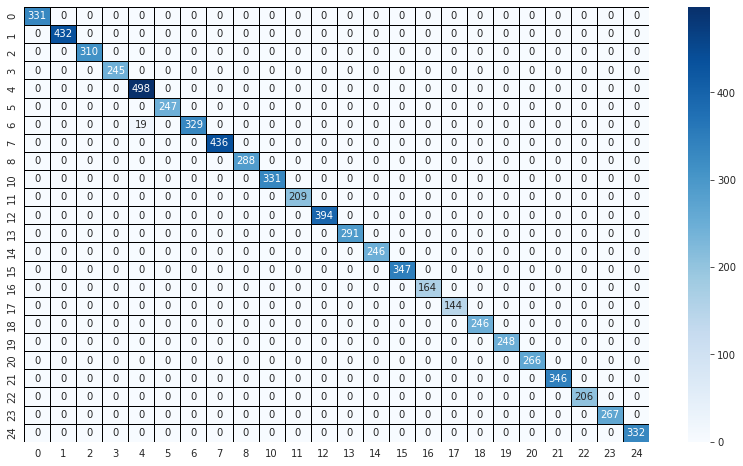

In [27]:
plt.figure()
_ = sns.heatmap(cm, cmap="Blues", linecolor="black", linewidth=1, annot=True, fmt="")

plt.show()

As we can notice on the confusion matrix, the model is able to classify the sign language signs correctly for all the test images. No overfitting was introduced as the model is able to generalize well for the data it has never seen before.

In [28]:
correct = predictions[predictions == y]
correct.shape


(7153,)

Examples of the predictions of the model are shown below.

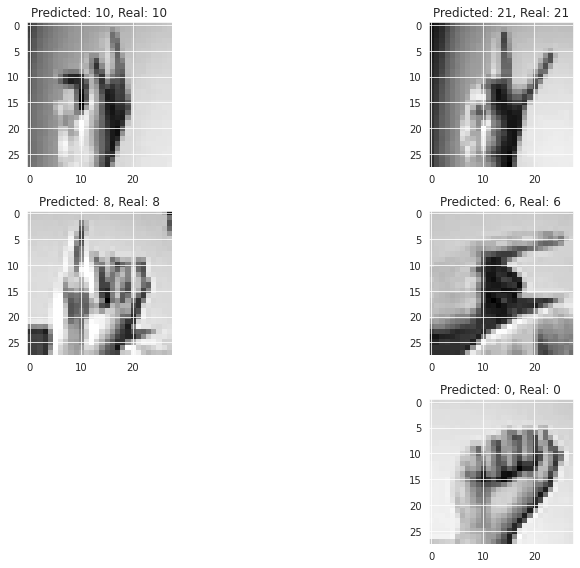

In [29]:
i = 0
plt.figure()
for c in correct[:6]:
    plt.subplot(3, 2, i + 1)
    plt.imshow(x_test[c].reshape(28, 28), cmap="gray", interpolation="none")
    plt.title(f"Predicted: {predictions[c]}, Real: {y[c]}")
    plt.tight_layout()
    i += 1

plt.show()